In [1]:
import torch
from PIL import Image
from torch import nn, save, load
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torch.optim as optim
from torchsummary import summary
import torch.optim.lr_scheduler as scheduler
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = '~/ML/Supervised Learning/Pizza/pizza_not_pizza'
if torch.backends.mps.is_built() and torch.backends.mps.is_available():
    device = torch.device('mps')
else: device = torch.device('cpu')
device

device(type='mps')

In [3]:
def get_mean_and_std(loader):
  mean = 0. 
  std = 0.
  count = 0
  pbar = tqdm(loader)
  for batch in pbar:
    images,_ = batch
    curr_count = images.size(0)
    images = images.view(curr_count, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    count += curr_count

  mean /= count
  std /= count
  return mean, std


In [4]:
transforms_ = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomResizedCrop(512),
    transforms.RandomHorizontalFlip(p = 0.25)
])
data = datasets.ImageFolder(root=path, transform=transforms_)
dataloader = DataLoader(data, batch_size=64)
mean, std = get_mean_and_std(dataloader)
transforms_ = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomResizedCrop(512),
    transforms.RandomHorizontalFlip(p = 0.25),
    transforms.Normalize(mean=mean, std=std)
])
data = datasets.ImageFolder(root=path, transform=transforms_)
train, valid = random_split(data, [1766, 200])
trainloader = DataLoader(train, batch_size=4, shuffle=True)
validloader = DataLoader(valid, batch_size=4, shuffle=True)
images, label = next(iter(trainloader))

100%|██████████| 31/31 [00:12<00:00,  2.54it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


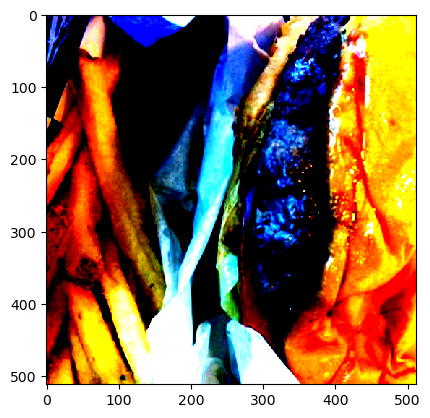

In [5]:
plt.imshow(np.transpose(images[0].numpy(), (1, 2, 0)))

In [6]:
class PizzaClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.AvgPool_4 = nn.Sequential(
            nn.AvgPool2d(3, 3)
        )
        self.AvgPool_16 = nn.Sequential(
            nn.AvgPool2d(3, 3)
        )
        self.AvgPool_64 = nn.Sequential(
            nn.AvgPool2d(3, 3)
        )
        self.AvgPool_256 = nn.Sequential(
            nn.AvgPool2d(3, 3)
        )
        self.AvgPool = nn.Sequential(
            nn.AvgPool2d(3)
        )
        self.conv2d_4 = nn.Sequential(
            nn.Conv2d(4, 4, (5, 5)),
            nn.BatchNorm2d(4),
            nn.ReLU()
        )
        self.conv2d_16 = nn.Sequential(
            nn.Conv2d(16, 16, (5, 5)),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.conv2d_64 = nn.Sequential(
            nn.Conv2d(64, 64, (5, 5)),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.conv2d_256 = nn.Sequential(
            nn.Conv2d(256, 256, (5, 5)),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.conv2d_3_4 = nn.Sequential(
            nn.Conv2d(3, 4, (5, 5)),
            nn.BatchNorm2d(4),
            nn.ReLU()
        )
        self.conv2d_4_16 = nn.Sequential(
            nn.Conv2d(4, 16, (5, 5)),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.conv2d_16_64 = nn.Sequential(
            nn.Conv2d(16, 64, (5, 5)),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.conv2d_64_256 = nn.Sequential(
            nn.Conv2d(64,256, (5, 5)),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.output = nn.Sequential(
            nn.Flatten(),
            nn.Linear(350464, 2)
        )
    def forward(self, x): 
      x = self.conv2d_3_4(x)

      x = self.conv2d_4(x)
      x = self.conv2d_4(x)

      x = self.conv2d_4_16(x)

      x = self.conv2d_16(x)
      x = self.AvgPool(x)
      x = self.conv2d_16(x)

      x = self.conv2d_16_64(x)

      x = self.conv2d_64(x)
      x = self.conv2d_64(x)

      x = self.conv2d_64_256(x)

      x = self.conv2d_256(x)
      x = self.conv2d_256(x)
      x = self.AvgPool(x)
      x = self.conv2d_256(x)
      x = self.conv2d_256(x)

      x = self.output(x)
      return x


clf = PizzaClassifier().to(device)
opt = Adam(clf.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss().to(device)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.9)
summary(clf.cpu(), (3, 512, 512))
#4 16 64 256

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 508, 508]             304
       BatchNorm2d-2          [-1, 4, 508, 508]               8
              ReLU-3          [-1, 4, 508, 508]               0
            Conv2d-4          [-1, 4, 504, 504]             404
       BatchNorm2d-5          [-1, 4, 504, 504]               8
              ReLU-6          [-1, 4, 504, 504]               0
            Conv2d-7          [-1, 4, 500, 500]             404
       BatchNorm2d-8          [-1, 4, 500, 500]               8
              ReLU-9          [-1, 4, 500, 500]               0
           Conv2d-10         [-1, 16, 496, 496]           1,616
      BatchNorm2d-11         [-1, 16, 496, 496]              32
             ReLU-12         [-1, 16, 496, 496]               0
           Conv2d-13         [-1, 16, 492, 492]           6,416
      BatchNorm2d-14         [-1, 16, 4

In [7]:
accuracy_plot = np.array([])
train_loss = np.array([])
train_accuracy = np.array([])

In [14]:
clf = clf.to(device)
loss_fn = loss_fn.to(device)
for epoch in range(1):
    pbar = tqdm(trainloader)
    clf.train()
    correct = 0
    incorrect = 0
    loss = 0.0
    for i, batch in enumerate(pbar):
        X, y = batch
        X = X.to(device)
        y = y.to(device)
        outputs = clf(X)
        _, preditced = torch.max(outputs.data, 1)
        correct += (preditced == y).float().sum()
        incorrect += (preditced != y).float().sum()
        loss = loss_fn(outputs, y)
        loss += loss.item()
        opt.zero_grad()
        loss.backward()
        opt.step()
    scheduler.step()
    train_accuracy = np.append(train_accuracy.cpu() * 100, correct.cpu() / (correct.cpu() + incorrect.cpu()))
    train_loss = np.append(train_loss.cpu(), loss / len(trainloader))
    pbar = tqdm(validloader)
    clf.eval()
    correct = 0
    incorrect = 0
    with torch.no_grad():
        for i, batch in enumerate(pbar):
            X, y = batch
            X = X.to(device)
            y = y.to(device)
            outputs = clf(X)
            _, preditced = torch.max(outputs.data, 1)
            correct += (preditced == y).float().sum()
            incorrect += (preditced != y).float().sum()
    accuracy_plot = np.append(accuracy_plot.cpu() * 100, correct.cpu() / (correct.cpu() + incorrect.cpu()))


    print(f"Epoch: {epoch + 1} Valid Accuracy: {accuracy_plot[-1]} Train Accuracy: {train_accuracy[-1]} Train Loss: {train_loss[-1]}")
plt.plot(accuracy_plot, label='Valid Accuracy')
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(train_loss, 'Train Loss')
# plt.legend(['Valid Accuracy', 'Train Accuracy'], 'train_loss')
plt.show()


  5%|▍         | 21/442 [00:40<13:36,  1.94s/it]


KeyboardInterrupt: 

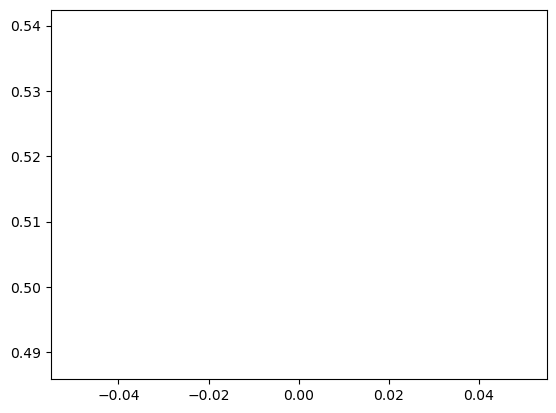

In [9]:
plt.plot(train_accuracy)

In [ ]:
plt.plot(accuracy_plot)

In [ ]:
plt.plot(train_loss)